A lot of thw work done in this notebook is based on the work by >>> https://medium.com/@shsu14/introduction-to-data-science-custom-twitter-word-clouds-704ec5538f46

### Step 1: Install Necessary packages

#### 1.1. Twython 
We'll need the **twython** package, so installing it first, based on conda package >> https://anaconda.org/conda-forge/twython

In [1]:
conda install -c conda-forge/label/gcc7 twython

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


#### Step 1.2: Install WordClouds and Stop Words

In [3]:
conda install -c conda-forge wordcloud

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\bishw\Anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         182 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    matplotlib-base-3.1.2      |   py37h2981e6d_1         6.6 MB  conda-forge
    openssl-1.1.1d             |       hfa6e2cd_0         4.7 MB  conda-forge
    wordcloud-1.6.0            |   py37hfa6e2cd_0         186 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        11.8 MB

The following NEW packages will be INSTALLED:

  matplotlib-base    conda-forge/win-64::matplotlib-base-3.1.2-py37h2981e6d_1
  wordcloud          conda-forge/win-64::wordcloud-1.6.0

### Step 2: Import the necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from twython import Twython
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im

### Step 3: Collect the data

The next step is to connect to the Twitter API with the Twython package in order to extract the raw Tweets from the chosen user handle.

In [2]:
#Connect to Twitter
APP_KEY = "..."
APP_SECRET = "...."
twitter = Twython(APP_KEY, APP_SECRET)

We can now call the function on a user timeline. Note that Twitter limits how far one can go back on a user’s timeline, which is 3200 at this point in time for free tier. While not as simple as the other parts of creating the word cloud, the following block of code checks for the most recent id and uses that as a placeholder to get the next batch of 200 tweets.

In [7]:
#Get timeline 
user_timeline=twitter.get_user_timeline(screen_name='BernieSanders',count=1) 
#get most recent id
last_id = user_timeline[0]['id']-1
for i in range(16):
    batch = twitter.get_user_timeline(screen_name='BernieSanders',count=200, max_id=last_id)
    user_timeline.extend(batch)
    last_id = user_timeline[-1]['id'] - 1

In [8]:
user_timeline[0:5]

[{'created_at': 'Sun Dec 15 00:28:30 +0000 2019',
  'id': 1206008092141293568,
  'id_str': '1206008092141293568',
  'text': 'For too long, voters have been told to settle for less. Our campaign is doing the opposite. The only way we defeat… https://t.co/phDZS6GSZS',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/phDZS6GSZS',
     'expanded_url': 'https://twitter.com/i/web/status/1206008092141293568',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [116, 139]}]},
  'source': '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 216776631,
   'id_str': '216776631',
   'name': 'Bernie Sanders',
   'screen_name': 'BernieSanders',
   'location': 'Vermont',
   'description': 'U.S. Senator from Vermon

We can see that the “text” field of each tweet contains the information we need. Furthermore, it appears that our timeline data is a list of dictionaries, so we can iterate through the list and grab each value with the “text” key.

In [9]:
#Extract textfields from tweets
raw_tweets = []
for tweets in user_timeline:
    raw_tweets.append(tweets['text'])

In [10]:
raw_tweets

['For too long, voters have been told to settle for less. Our campaign is doing the opposite. The only way we defeat… https://t.co/phDZS6GSZS',
 'I’m outraged, @MLB. Threatening to walk away from the entire minor league system is the exact opposite of negotiati… https://t.co/pG34DcO5ma',
 'RT @SEIU: "What really stuck with me is the passion in his voice when he spoke about fixing the issues that I had &amp; that many other people…',
 "Our goal: to leave a better country and world for @KillerMike's son and all our children. https://t.co/uZ9ocrRY0I",
 'RT @mistyrebik: Bernie has righteous anger towards corporate greed. He will bring that to the White House. He will fight for working people…',
 'If pitchers can make $324 million, we can pay every teacher in this country at least $60,000. https://t.co/u6rPy9uI3j',
 'RT @AFTunion: At a time of massive income and wealth inequality, when many of our school districts are underfunded, when educators are leav…',
 'Seven years ago, 20 children an

While this is an interesting collection of tweets, it does not generate any addiitonal value compared to just scrolling the tweets manually. So let's clean this for analysis.

### Step 4: Clean the data

At this point, we have our raw data - all URL links, special characters, emojis, and extra white spaces. We'll remove them on a case by case basis.

In [11]:
#Create a string form of our list of text
raw_string = ''.join(raw_tweets)
no_links = re.sub(r'http\S+', '', raw_string)
no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links)
no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode)

Now we get rid of words like 'a', 'an', 'the', 'being' etc. called **StopWords**

In [12]:
# Set stopwords
stopwords = set(STOPWORDS)

In [13]:
words = no_special_characters.split(" ")
words = [w for w in words if len(w) > 2]  # ignore a, an, be, ...
words = [w.lower() for w in words]
words = [w for w in words if w not in stopwords]
words_bern = ','.join(words) # Create clean string of words

### Step 5: Visualize Data with Mask

First we obtain the mask image that will outline the wordcloud

In [20]:
mask = np.array(Image.open('/Users/bishw/Desktop/DataScience/DS_UCsd/1 Python/Final Project/2020.png'))

Create the word cloud instance (note that the documentation requires that the text be in a string format):

In [11]:
# Create word cloud
wc_bern = WordCloud(background_color="white", max_words=2000, mask=mask)
wc_bern.generate(words_bern)

And finally sdisplay the image:

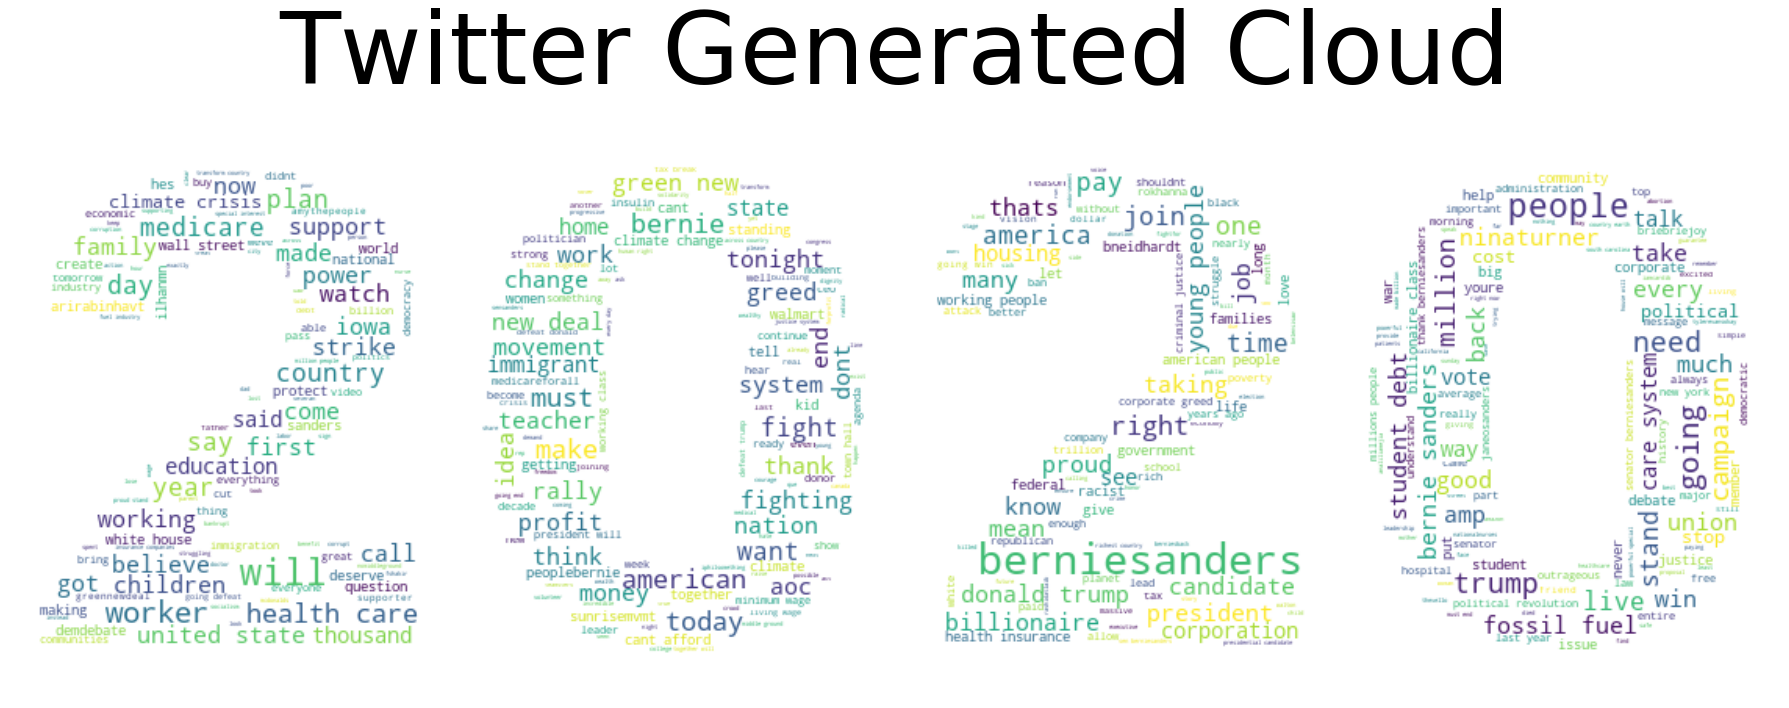

In [13]:
f = plt.figure(figsize=(70,70))
#f.add_subplot(1,2, 1)
#plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
#plt.title('Original Stencil', size=40)
#plt.axis("off")
f.add_subplot(1,2, 2)
plt.imshow(wc_bern, interpolation='bilinear')
plt.title('Twitter Generated Cloud', size=100)
plt.axis("off")
plt.show()

### Step 6: Repeat for Trump

In [22]:
#Get timeline 2 
user_timeline=twitter.get_user_timeline(screen_name='realDonaldTrump',count=1) 
#get most recent id
last_id = user_timeline[0]['id']-1
for i in range(16):
    batch = twitter.get_user_timeline(screen_name='realDonaldTrump',count=200, max_id=last_id)
    user_timeline.extend(batch)
    last_id = user_timeline[-1]['id'] - 1

In [23]:
#Extract textfields from tweets
raw_tweets = []
for tweets in user_timeline:
    raw_tweets.append(tweets['text'])

In [24]:
#Create a string form of our list of text
raw_string = ''.join(raw_tweets)
no_links = re.sub(r'http\S+', '', raw_string)
no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links)
no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode)

In [25]:
words = no_special_characters.split(" ")
words = [w for w in words if len(w) > 2]  # ignore a, an, be, ...
words = [w.lower() for w in words]
words = [w for w in words if w not in stopwords]
words_trump = ','.join(words) # Create clean string of words

In [26]:
# Create word cloud
wc_trump = WordCloud(background_color="white", max_words=2000, mask=mask)
wc_trump.generate(words_trump)

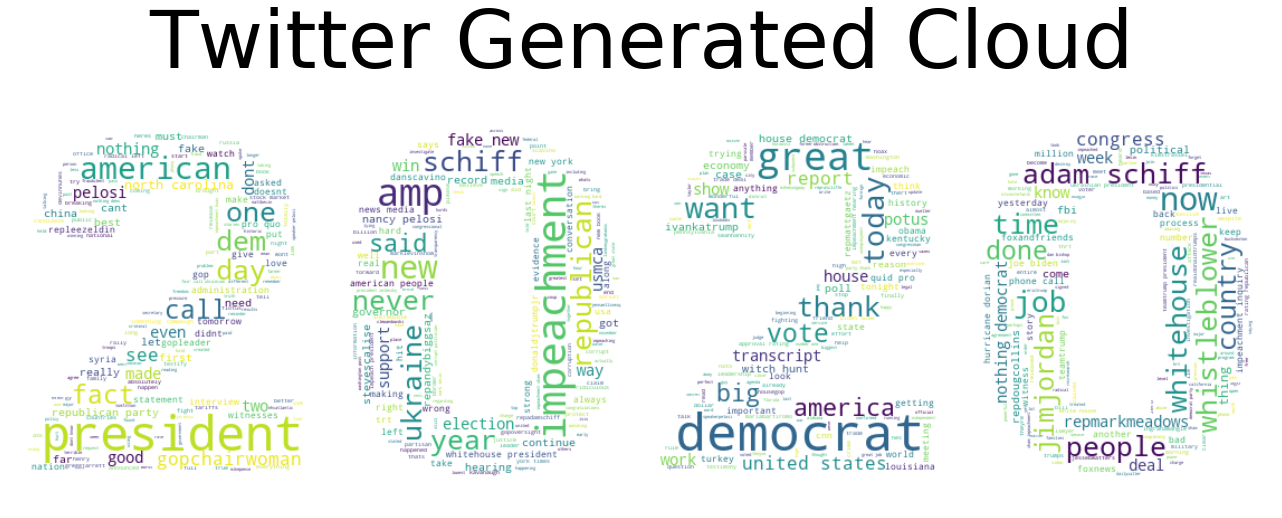

In [27]:
# visualize word cloud
f = plt.figure(figsize=(50,50))
#f.add_subplot(1,2, 1)
#plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
#plt.title('Original Stencil', size=40)
#plt.axis("off")
f.add_subplot(1,2, 2)
plt.imshow(wc_trump, interpolation='bilinear')
plt.title('Twitter Generated Cloud', size=80)
plt.axis("off")
plt.show()

### Step 7: Refine the visualization

While this gives us some idea about the major talking points, it is still not very useful to drive a lot of meaningful insight. We shall try if condensing the wordcloud may help 

First, let's add some additional words like 'Bernie', 'Sanders', 'Trump', 'Donald Trump' etc., which do not provide any valuable insights on the policy and agenda of the candidates, and **add additional words to the stopwords.**

In [14]:
# Add stopwords
#word_list = ['bernie','sanders','bernie sanders', 'realdonaldtrump', 'donald', 'trump', 'say', 'many', 'much', 'nancy','nancy pelosi','pelosi']
#for i in word_list:
 #   stopwords.add(word_list[i]) 
stopwords.add('say')
stopwords.add('bernie')
stopwords.add('sanders')
stopwords.add('berniesanders')
stopwords.add('realdonaldtrump')
stopwords.add('trump')
stopwords.add('many')
stopwords.add('much')
stopwords.add('nancypelosi')
stopwords.add('donald')
stopwords.add('trump')
stopwords.add('will')
stopwords.add('going')

**Creating new word cloud with additional stopwords - Bernie Sanders**

In [15]:
# Create WordCloud Object - BernieSanders
# instantiate a word cloud object
wc_bern = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask
)

# generate the word cloud
wc_bern.generate(words_bern)


NameError: name 'mask' is not defined

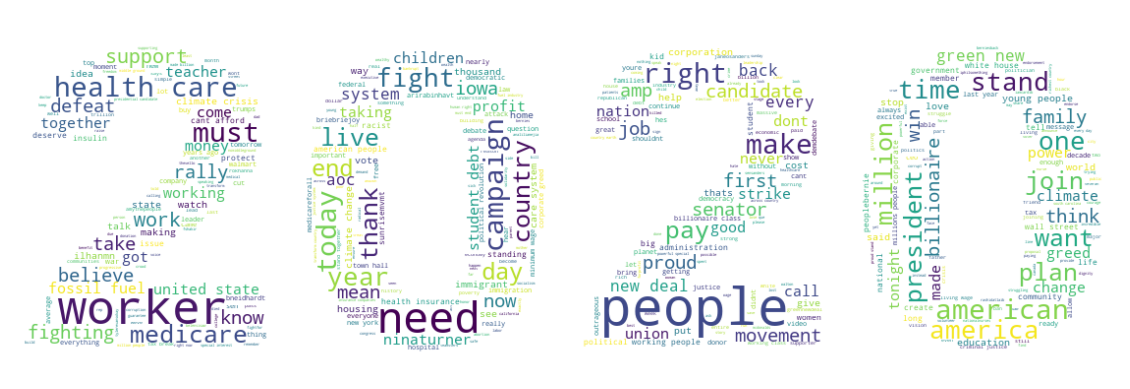

In [41]:
# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_bern, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's see if the visualization looks better in a different i.e. circular mask.

In [16]:
mask2 = np.array(Image.open('/Users/bishw/Desktop/DataScience/DS_UCsd/1 Python/Final Project/round.png'))

Recreating the wordcloud.

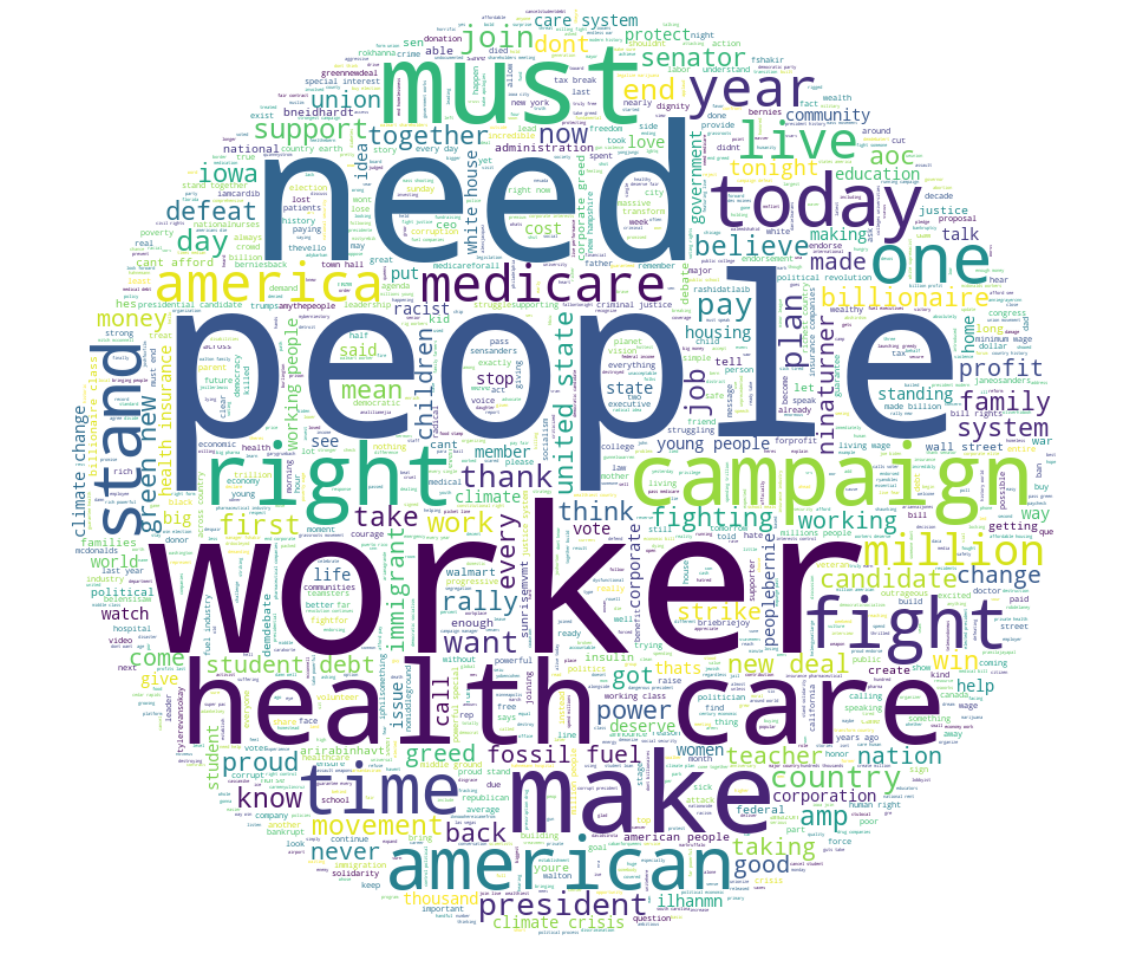

In [17]:
# Create WordCloud Object - BernieSanders - Circular mask
# instantiate a word cloud object
wc_bern = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask2
)

# generate the word cloud
wc_bern.generate(words_bern)
# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(20) # set height

plt.imshow(wc_bern, interpolation='bilinear')
plt.axis('off')
plt.show()

**Repeating the process for Donald Trump**

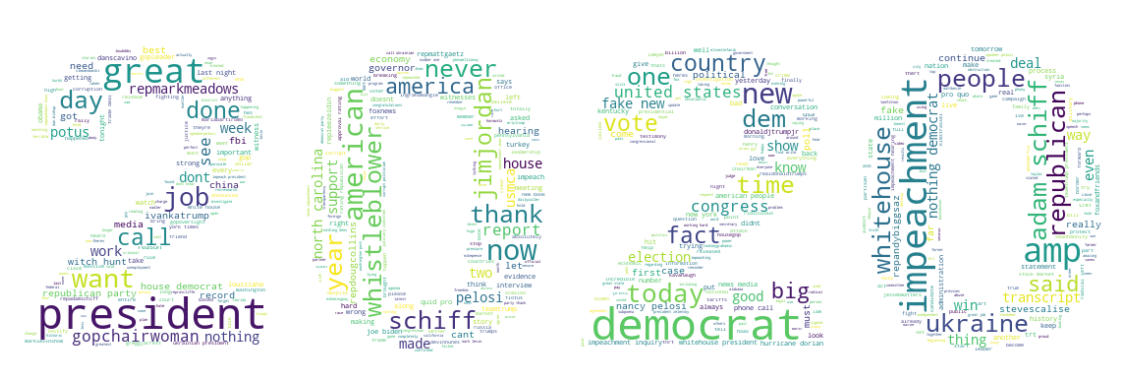

In [28]:
# Create WordCloud Object - Donald Trump
# instantiate a word cloud object
wc_trump = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask
)

# generate the word cloud

wc_trump.generate(words_trump)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_trump, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's also see the word cloud in circular mask, which is more easier to understand

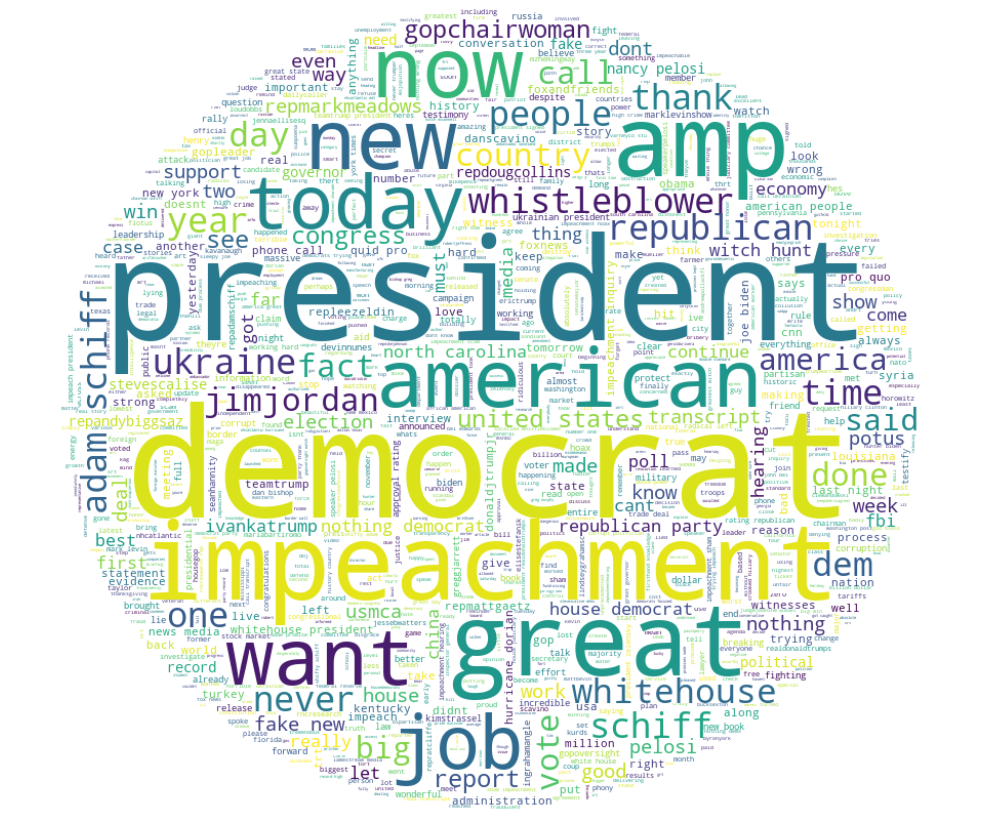

In [29]:
# Create WordCloud Object - Donald Trump
# instantiate a word cloud object
wc_trump = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask2
)

# generate the word cloud
wc_trump.generate(words_trump)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_trump, interpolation='bilinear')
plt.axis('off')
plt.show()

### While these stopwords and visualization seem to work fine, it feels like on-boarding more candidates in the presidential race, esp. Senator Warren and VP Joe Biden might be useful for more understanding of the political spectrum.

#### Quickly Collecting and Cleaning Data for Sen Warren

In [30]:
#Get timeline 3 
user_timeline=twitter.get_user_timeline(screen_name='ewarren',count=1) 
#get most recent id
last_id = user_timeline[0]['id']-1
for i in range(16):
    batch = twitter.get_user_timeline(screen_name='ewarren',count=200, max_id=last_id)
    user_timeline.extend(batch)
    last_id = user_timeline[-1]['id'] - 1
    
#Extract textfields from tweets
raw_tweets = []
for tweets in user_timeline:
    raw_tweets.append(tweets['text'])
    
#Create a string form of our list of text
raw_string = ''.join(raw_tweets)
no_links = re.sub(r'http\S+', '', raw_string)
no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links)
no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode)

words = no_special_characters.split(" ")
words = [w for w in words if len(w) > 2]  # ignore a, an, be, ...
words = [w.lower() for w in words]
words = [w for w in words if w not in stopwords]
words_warren = ','.join(words) # Create clean string of words

#### Quickly visualizing word cloud with round mask for Sen Warren

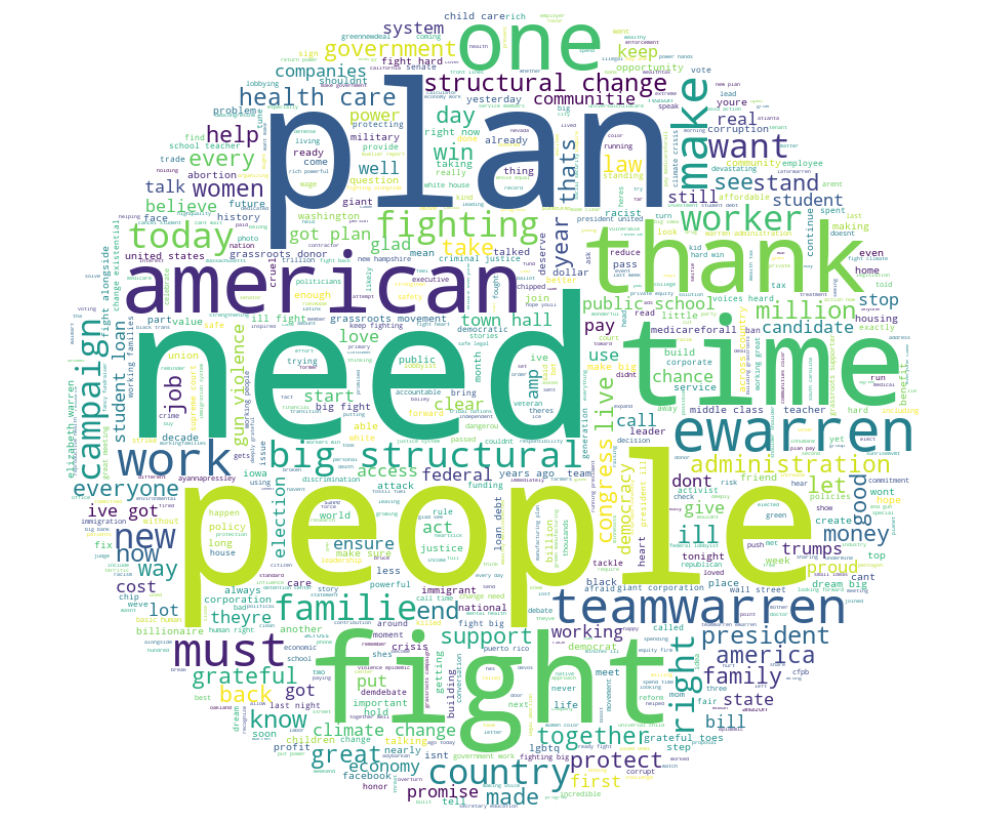

In [31]:
# Create WordCloud Object - Elizabeth Warren
# instantiate a word cloud object
wc_warren = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask2
)

# generate the word cloud
wc_warren.generate(words_warren)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_warren, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Add Stopwords...

In [32]:
stopwords.add('make')
stopwords.add('made')
stopwords.add('ewarren')
stopwords.add('teamwarren')

#### Final Visualization

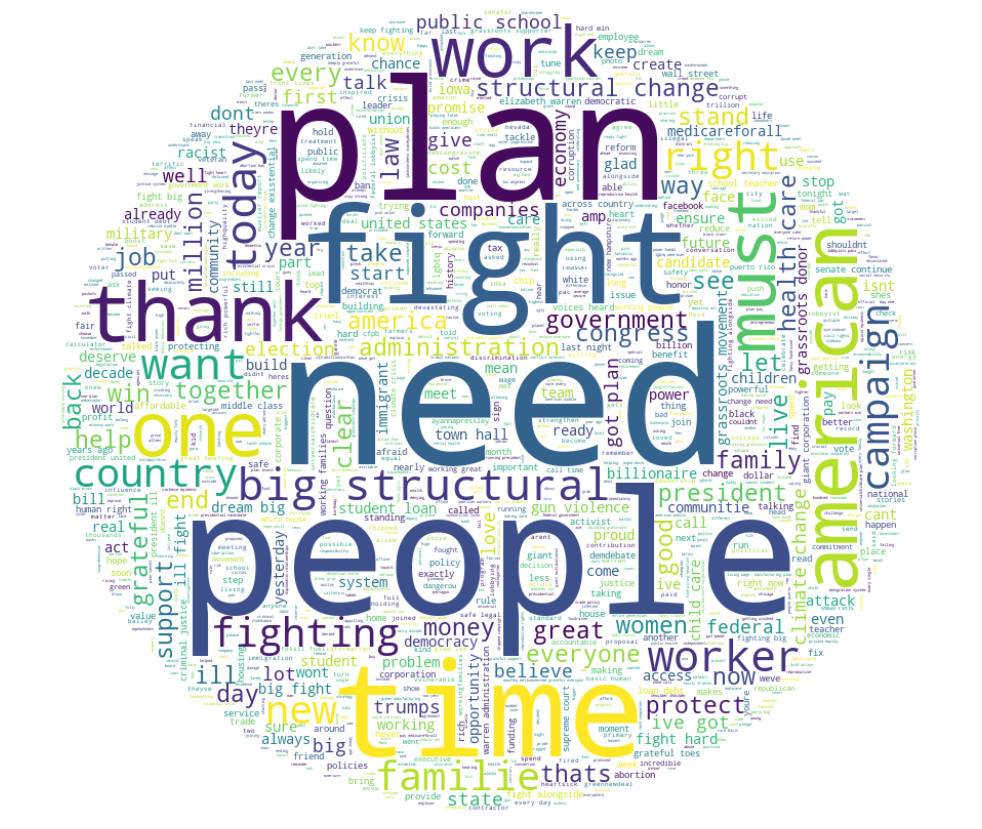

In [34]:
# Create WordCloud Object - Elizabeth Warren
# instantiate a word cloud object
wc_warren = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask2
)

# generate the word cloud
wc_warren.generate(words_warren)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_warren, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Quickly collecting and Cleaning Data for Joe Biden

In [35]:
#Get timeline 3 
user_timeline=twitter.get_user_timeline(screen_name='JoeBiden',count=1) 
#get most recent id
last_id = user_timeline[0]['id']-1
for i in range(16):
    batch = twitter.get_user_timeline(screen_name='JoeBiden',count=200, max_id=last_id)
    user_timeline.extend(batch)
    last_id = user_timeline[-1]['id'] - 1
    
#Extract textfields from tweets
raw_tweets = []
for tweets in user_timeline:
    raw_tweets.append(tweets['text'])
    
#Create a string form of our list of text
raw_string = ''.join(raw_tweets)
no_links = re.sub(r'http\S+', '', raw_string)
no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links)
no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode)

words = no_special_characters.split(" ")
words = [w for w in words if len(w) > 2]  # ignore a, an, be, ...
words = [w.lower() for w in words]
words = [w for w in words if w not in stopwords]
words_biden = ','.join(words) # Create clean string of words

#### Quickly visualizing word cloud for Joe Biden

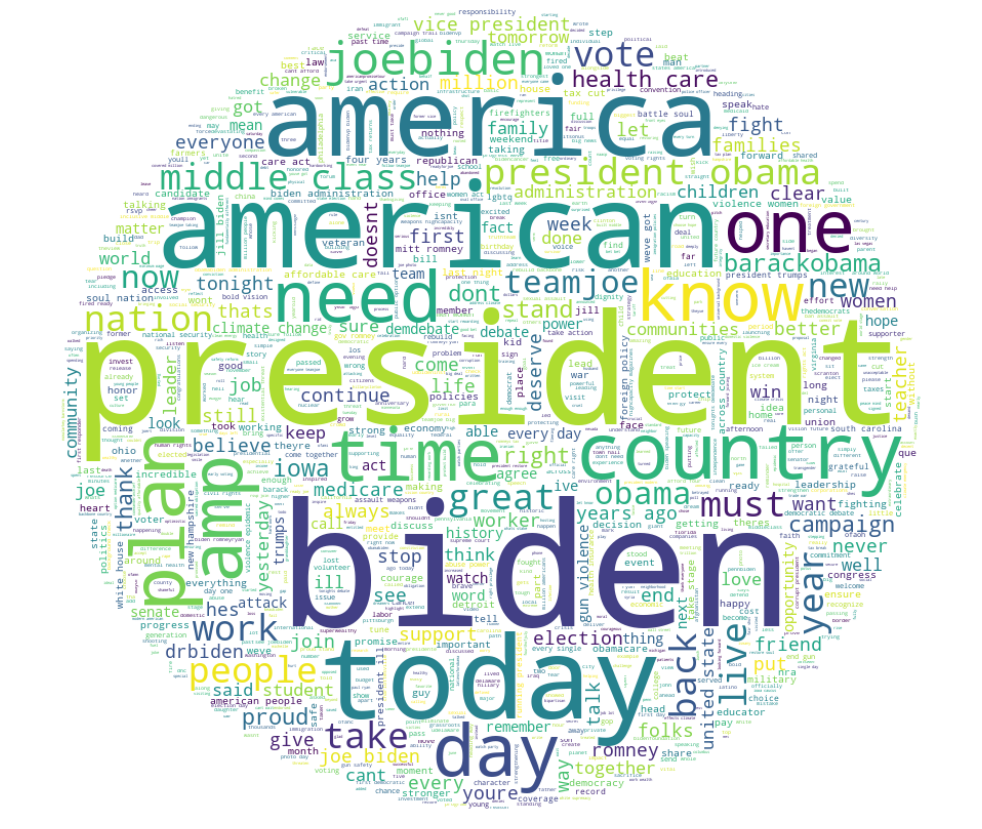

In [36]:
# Create WordCloud Object - Elizabeth Warren
# instantiate a word cloud object
wc_biden = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask2
)

# generate the word cloud
wc_biden.generate(words_biden)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_biden, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Add new stopwords..

In [37]:
stopwords.add('joebiden')
stopwords.add('amp')
stopwords.add('biden')

#### Final Visualization

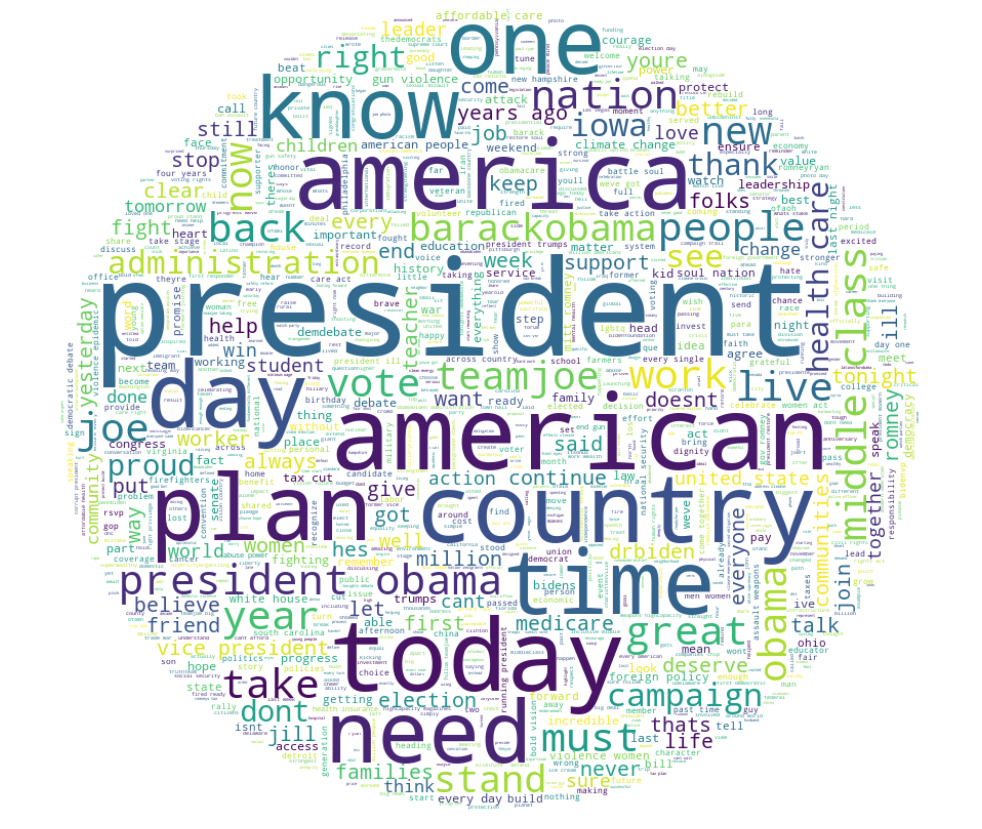

In [39]:
# Create WordCloud Object - Elizabeth Warren
# instantiate a word cloud object
wc_warren = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords, 
    mask = mask
)

# generate the word cloud
wc_biden.generate(words_biden)

# Display word cloud
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(15) # set height

plt.imshow(wc_biden, interpolation='bilinear')
plt.axis('off')
plt.show()